In [1]:
import pandas as pd
import sys
import numpy as np
from tqdm.auto import tqdm
import matplotlib.pyplot as plt

/home/pmac/anaconda3/envs/afs/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
from SVEA_funcs import CS_SVEA

In [3]:
def get_seqs(path, key='Sequence'):
  df = pd.read_csv(path)
  return list(df[key])

In [4]:
# import importlib
# import sys
# importlib.reload(sys.modules['feature_utils'])
from feature_utils import get_OAAC
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

AAs = ['A', 'R', 'N', 'D', 'C', 'E', 'Q', 'G', 'H', 'I', 'L', 'K', 'M', 'F', 'P', 'S', 'T', 'W', 'Y', 'V']

class FeatureExtractor(object):
  def __init__(self, feature_func, **kwargs):
    self.feature_func = feature_func
    self.kwargs = kwargs
    
  def __call__(self, seq):
    return self.feature_func(seq, **self.kwargs)

  
def get_X(seq_list, k=1, AAs=AAs, max_len=np.inf, min_len=-np.inf, normalize=True):
  X = []
  for seq in tqdm(seq_list, total=len(seq_list)):
    if len(seq)<=max_len and len(seq)>=min_len:
      X.append(get_OAAC(seq, k=k, AAs=AAs, normalize=normalize))
  return np.array(X)

In [5]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV
import matplotlib.pyplot as plt
import sklearn.metrics as sk_metrics
from sklearn.model_selection import StratifiedKFold

scoring_metrics = {'AM':'balanced_accuracy', 'acc':'accuracy'}
def findSVM(X,y, n_folds=3, metric='accuracy', class_weight=None, random_state=None, intercept=True):
    svm = LinearSVC(class_weight=class_weight, dual = False, random_state=random_state, max_iter=int(1e4), fit_intercept=intercept)
    # svm = LinearSVC(class_weight=class_weight, dual = True, loss='hinge', random_state=random_state, max_iter=int(1e7), fit_intercept=intercept)
    C_vals = np.logspace(-1, 3, 5)

    tuned_parameters = [{"C": C_vals}]
    cv = StratifiedKFold(n_splits=n_folds, random_state=random_state, shuffle=True)
    clf = GridSearchCV(svm, tuned_parameters, cv=cv, scoring=list(scoring_metrics.values()), refit=metric, n_jobs=2)
    clf.fit(X, y)

    return clf

n_folds = 5

def get_scores(X,y,X_test,y_test, metric='AM', class_weight='balanced', n_folds=n_folds, intercept=True):
  clf = findSVM(X,y,n_folds=n_folds, metric=scoring_metrics[metric], class_weight=class_weight, random_state=42, intercept=intercept)
  
  scores = {
    'train_mean_AM': np.round(clf.cv_results_['mean_test_'+scoring_metrics['AM']][clf.best_index_],3),
    'train_std_AM': np.round(clf.cv_results_['std_test_'+scoring_metrics['AM']][clf.best_index_],3),
    'train_mean_acc': np.round(clf.cv_results_['mean_test_'+scoring_metrics['acc']][clf.best_index_],3),
    'train_std_acc': np.round(clf.cv_results_['std_test_'+scoring_metrics['acc']][clf.best_index_],3),
    'test_AM': np.round(sk_metrics.balanced_accuracy_score(y_test, clf.predict(X_test)),3),
    'test_acc': np.round(sk_metrics.accuracy_score(y_test, clf.predict(X_test)),3)
  }
  
  return scores, clf

In [6]:
def get_X_y(feature_func, C1_path, C2_path):
  df = pd.read_csv(C1_path)
  X1 = feature_func(list(df['Sequence']))
  y1 = np.ones(X1.shape[0])
  df = pd.read_csv(C2_path)
  X2 = feature_func(list(df['Sequence']))
  y2 = -np.ones(X2.shape[0])
  X = np.concatenate([X1, X2])
  y = np.concatenate([y1, y2])
  print('C1 #', y1.shape[0], '| C2 #', y2.shape[0])
  return X,y

In [7]:
def get_non_identical_seqs(C1_train_path, C2_train_path=None, C1_test_path=None, C2_test_path=None):
  if C2_train_path:
    train_seqs = get_seqs(C1_train_path)+get_seqs(C2_train_path)
  else:
    train_seqs = get_seqs(C1_train_path)
  if not C1_test_path:
    filtered_seqs = []
    filtered_indices = []
    for i, seq in enumerate(train_seqs):
      if seq not in filtered_seqs:
        filtered_seqs.append(seq)
        filtered_indices.append(i)
  
    # print('After filtering identical seqeunces', len(filtered_indices), '/', len(train_seqs))
    return filtered_indices
    
  # train_seqs = get_seqs(C1_train_path)+get_seqs(C2_train_path)
  test_seqs = get_seqs(C1_test_path)+get_seqs(C2_test_path)

  filtered_test_seqs = []
  filtered_indices = []
  for i, seq in enumerate(test_seqs):
    if seq not in train_seqs:
      if seq not in filtered_test_seqs:
        filtered_test_seqs.append(seq)
        filtered_indices.append(i)

  print('Filtered', len(filtered_indices), '/', len(test_seqs))
  return filtered_indices

In [8]:
def plot_vals(vals, cutoff=None, label=''):
  plt.scatter(np.arange(len(vals)), np.sort(vals), c='blue')
  plt.plot(np.arange(len(vals)), np.sort(vals), c='blue')
  # plt.axhline(y = 0.5*sum(SV_vals)/len(SV_vals), c = 'black', linestyle = '--')
  if cutoff:
    plt.axhline(y = cutoff, label='$\phi_{cutoff}$', c = 'black', linestyle = '--')
  # plt.axhline(y = sum(SV_vals), c = 'black', linestyle = '-')
  plt.xticks(np.arange(len(vals)), [AAs[i] for i in np.argsort(vals)])
  plt.yticks(np.arange(0,1,0.05))
  plt.ylim(0,0.25)
  plt.locator_params(axis='y', nbins=20)
  plt.xlabel('Amino Acids', fontsize=15)
  plt.ylabel(label+' ($\phi(i)$)', fontsize=15)
  plt.legend(fontsize=15)
  # plt.show()
  return plt

In [9]:
from sklearn.model_selection import train_test_split
feature_extractor = FeatureExtractor(get_X, k=1, AAs=AAs)

def get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor=feature_extractor):

  print('-> Extracting features:')
  
  X, y = get_X_y(feature_extractor, C1_train_path, C2_train_path)
  print('-> Filter identical sequences')
  filtered_indices  = get_non_identical_seqs(C1_train_path, C2_train_path)
  X=X[filtered_indices]
  y=y[filtered_indices]
  if not C1_test_path:
    X, X_test, y, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
    print('Train | C1 #', (y==1).sum(), 'C2 #', (y==-1).sum())
    print('Test  | C1 #', (y_test==1).sum(), 'C2 #', (y_test==-1).sum())
  else:
    X_test, y_test = get_X_y(feature_extractor, C1_test_path, C2_test_path)
    filtered_indices  = get_non_identical_seqs(C1_train_path, C2_train_path, C1_test_path, C2_test_path)
    X_test = X_test[filtered_indices]
    y_test = y_test[filtered_indices]
    print('Train | C1 #', (y==1).sum(), '| C2 #', (y==-1).sum())
    print('Test  | C1 #', (y_test==1).sum(), '| C2 #', (y_test==-1).sum())

  print('Computing Shapley values')
  SV_vals = CS_SVEA(X,y, 500, seed=8, return_SV=True)
  plt = plot_vals(SV_vals, cutoff=sum(SV_vals)/len(SV_vals), label='Shapley values')
  

  afs = list(np.argsort(SV_vals)[np.sort(SV_vals)>=sum(SV_vals)/len(SV_vals)])

  print('Full')
  scores, clf_full  = get_scores(X, y, X_test, y_test, metric='AM', class_weight='balanced', intercept=False)
  print(scores)
  print('AFS')
  print('_'*25+'**SVEA**'+'_'*25)
  scores, clf_afs  = get_scores(X[:,afs], y, X_test[:,afs], y_test, metric='AM', class_weight='balanced', intercept=True)
  print(scores)

  print('AFS:',[AAs[i] for i in afs[::-1]])

  c1_feats = clf_afs.best_estimator_.coef_>0
  c2_feats = clf_afs.best_estimator_.coef_<0
  print('AFS(C1):',[AAs[afs[i]] for i in range(len(afs)) if c1_feats.T[i]][::-1])
  print('AFS(C2):',[AAs[afs[i]] for i in range(len(afs)) if c2_feats.T[i]][::-1])

  C1_afs = [AAs[afs[i]] for i in range(len(afs)) if c1_feats.T[i]]
  C2_afs = [AAs[afs[i]] for i in range(len(afs)) if c2_feats.T[i]]
  
  return C1_afs, C2_afs, SV_vals, plt

In [10]:
from file_utils import list_to_fasta, fasta_to_list
from Bio.Align.Applications import ClustalOmegaCommandline
from seq_view_utils import view_alignment
import panel as pn
# import panel.widgets as pnw
def get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix='C1', C2_suffix='C2', aln_saved=False, n1=15, n2=15):
  
  input_file = C1_train_path[:-4]+str(n1)+C2_train_path[:-4].split('/')[-1]+str(n2)+'.fasta'
  
  aln_file = input_file[:-5]+'aln'

  if not aln_saved:
    C1_train_seqs = get_seqs(C1_train_path)
    filtered_indices  = get_non_identical_seqs(C1_train_path)
    C1_train_seqs = [C1_train_seqs[i] for i in filtered_indices]
    C2_train_seqs = get_seqs(C2_train_path)
    filtered_indices  = get_non_identical_seqs(C2_train_path)
    C2_train_seqs = [C2_train_seqs[i] for i in filtered_indices]
    rng = np.random.default_rng(8)
    indices = rng.permutation(len(C1_train_seqs))[:n1]
    aln1_seqs = [C1_train_seqs[i] for i in indices]
    headers = get_seqs(C1_train_path, key='Entry')
    aln1_headers = [headers[i]+'|'+C1_suffix for i in indices]
    indices = rng.permutation(len(C2_train_seqs))[:n2]
    aln2_seqs = [C2_train_seqs[i] for i in indices]
    headers = get_seqs(C2_train_path, key='Entry')
    aln2_headers = [headers[i]+'|'+C2_suffix for i in indices]
    aln_seqs = aln1_seqs+aln2_seqs
    aln_headers = aln1_headers+aln2_headers
    list_to_fasta(aln_seqs, aln_headers, input_file)  
    clustalomega_cline = ClustalOmegaCommandline(infile=input_file, outfile=aln_file, verbose=True, iterations=5, outputorder='input-order', auto=True, force=True)
    clustalomega_cline()

  aln_seqs, headers = fasta_to_list(aln_file, returnHeader=True)

  attrs = np.zeros((len(aln_seqs), len(aln_seqs[0])))
  for i,seq in enumerate(aln_seqs):
    for j, AA in enumerate(seq):
      if AA in C1_afs:
        attrs[i][j] = SV_vals[AAs.index(AA)]/max(SV_vals)
      elif AA in C2_afs:
        attrs[i][j] = -SV_vals[AAs.index(AA)]/max(SV_vals)
      else:
        attrs[i,j] = 0.01


  pn.extension()
  
  p = view_alignment(aln_seqs, attrs, ids=headers, fontsize="8pt", plot_width=1800)
  return pn.pane.Bokeh(p)

/home/pmac/anaconda3/envs/afs/lib/python3.9/site-packages/Bio/Application/__init__.py:40: BiopythonDeprecationWarning: The Bio.Application modules and modules relying on it have been deprecated.

Due to the on going maintenance burden of keeping command line application
wrappers up to date, we have decided to deprecate and eventually remove these
modules.

We instead now recommend building your command line and invoking it directly
with the subprocess module.
  warnings.warn(


In [11]:
DATA_PATH = './datasets/'

# lysozyme / lactalbumin

In [12]:
family_PATH = DATA_PATH + 'lysozyme_like/'

In [13]:
C1_train_path = family_PATH+'alpha_lactalbumin_swissprot.csv'
C2_train_path = family_PATH+'lysozyme_c_swissprot.csv'
C1_test_path = family_PATH+'alpha_lactalbumin_trembl.csv'
C2_test_path = family_PATH+'lysozyme_c_trembl.csv'

-> Extracting features:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 81/81 [00:00<00:00, 29668.90it/s]


C1 # 22 | C2 # 81
-> Filter identical sequences


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 28039.00it/s]

C1 # 68 | C2 # 17
Filtered 67 / 85
Train | C1 # 22 | C2 # 74
Test  | C1 # 53 | C2 # 14
Computing Shapley values
Restricted license - for non-production use only - expires 2025-11-24



100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.53it/s]


Full
{'train_mean_AM': 1.0, 'train_std_AM': 0.0, 'train_mean_acc': 1.0, 'train_std_acc': 0.0, 'test_AM': 0.896, 'test_acc': 0.836}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.993, 'train_std_AM': 0.013, 'train_mean_acc': 0.99, 'train_std_acc': 0.02, 'test_AM': 0.898, 'test_acc': 0.881}
AFS: ['I', 'A', 'D', 'N', 'G', 'R', 'E', 'F', 'L', 'W']
AFS(C1): ['I', 'D', 'E', 'F', 'L']
AFS(C2): ['A', 'N', 'G', 'R', 'W']


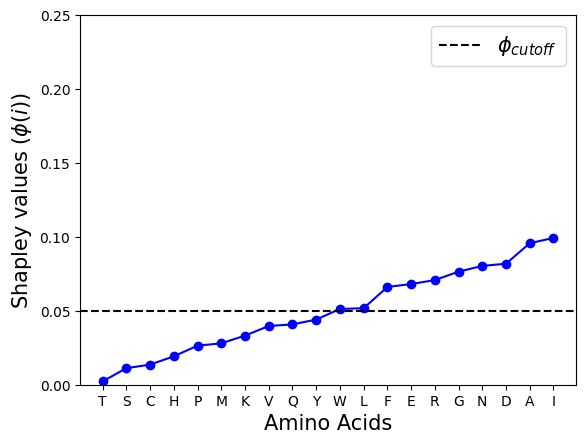

In [14]:
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [15]:
C1_suffix = 'lalba'
C2_suffix = 'lyzc'

p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)
p

Bokeh(GridPlot)

# Globins

In [16]:
family_PATH = DATA_PATH + 'globins/'

## myoglobin / hemoglobin alpha

In [17]:
C1_train_path = family_PATH+'myoglobin_swissprot.csv'
C2_train_path = family_PATH+'hemoglobin_alpha_swissprot.csv'
C1_test_path = family_PATH+'myoglobin_trembl.csv'
C2_test_path = family_PATH+'hemoglobin_alpha_trembl.csv'

-> Extracting features:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 317/317 [00:00<00:00, 29253.36it/s]


C1 # 126 | C2 # 317
-> Filter identical sequences


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 677/677 [00:00<00:00, 32949.75it/s]


C1 # 580 | C2 # 677
Filtered 1004 / 1257
Train | C1 # 107 | C2 # 303
Test  | C1 # 479 | C2 # 525
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.22it/s]


Full
{'train_mean_AM': 0.998, 'train_std_AM': 0.003, 'train_mean_acc': 0.998, 'train_std_acc': 0.005, 'test_AM': 0.968, 'test_acc': 0.969}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.994, 'train_std_AM': 0.009, 'train_mean_acc': 0.995, 'train_std_acc': 0.006, 'test_AM': 0.97, 'test_acc': 0.971}
AFS: ['E', 'S', 'Y', 'V', 'K', 'P', 'I', 'G', 'C', 'W']
AFS(C1): ['E', 'K', 'I', 'G', 'W']
AFS(C2): ['S', 'Y', 'V', 'P', 'C']


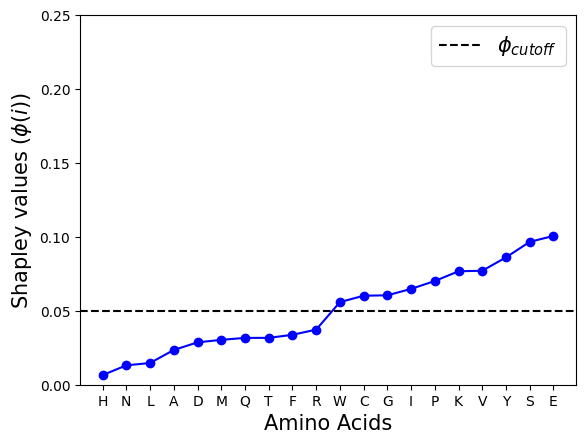

In [18]:
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [19]:
C1_suffix = 'Mb'
C2_suffix = 'Hba'
 
p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)
p

Bokeh(GridPlot)

## myoglobin / hemoglobin-$\beta$

In [20]:
C1_train_path = family_PATH+'myoglobin_swissprot.csv'
C2_train_path = family_PATH+'hemoglobin_beta_swissprot.csv'
C1_test_path = family_PATH+'myoglobin_trembl.csv'
C2_test_path = family_PATH+'hemoglobin_beta_trembl.csv'

-> Extracting features:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 30501.19it/s]


C1 # 126 | C2 # 312
-> Filter identical sequences


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 28849.41it/s]


C1 # 580 | C2 # 360
Filtered 740 / 940
Train | C1 # 107 | C2 # 285
Test  | C1 # 479 | C2 # 261
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.69it/s]


Full
{'train_mean_AM': 1.0, 'train_std_AM': 0.0, 'train_mean_acc': 1.0, 'train_std_acc': 0.0, 'test_AM': 0.957, 'test_acc': 0.949}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 1.0, 'train_std_AM': 0.0, 'train_mean_acc': 1.0, 'train_std_acc': 0.0, 'test_AM': 0.936, 'test_acc': 0.919}
AFS: ['K', 'V', 'C', 'E', 'W', 'N', 'F', 'M', 'Y', 'I']
AFS(C1): ['K', 'E', 'M', 'I']
AFS(C2): ['V', 'C', 'W', 'N', 'F', 'Y']


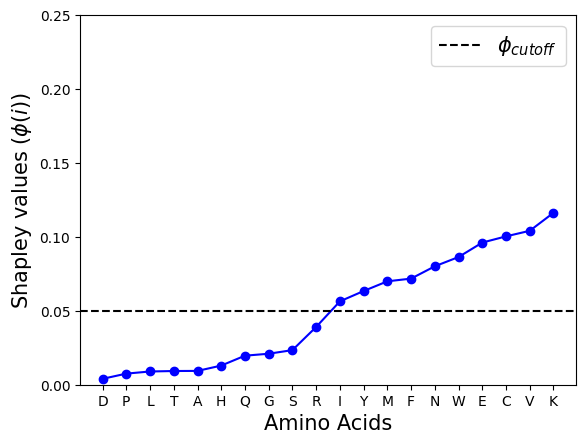

In [21]:
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [22]:
C1_suffix = 'Mb'
C2_suffix = 'Hbb'
 
p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)
p

Bokeh(GridPlot)

## hemoglobin-$\alpha$ / hemoglobin-$\beta$

In [23]:
C1_train_path = family_PATH+'hemoglobin_alpha_swissprot.csv'
C2_train_path = family_PATH+'hemoglobin_beta_swissprot.csv'
C1_test_path = family_PATH+'hemoglobin_alpha_trembl.csv'
C2_test_path = family_PATH+'hemoglobin_beta_trembl.csv'

-> Extracting features:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 312/312 [00:00<00:00, 30612.49it/s]


C1 # 317 | C2 # 312
-> Filter identical sequences


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 360/360 [00:00<00:00, 30686.29it/s]


C1 # 677 | C2 # 360
Filtered 786 / 1037
Train | C1 # 303 | C2 # 285
Test  | C1 # 525 | C2 # 261
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:02<00:00,  7.96it/s]


Full
{'train_mean_AM': 0.983, 'train_std_AM': 0.008, 'train_mean_acc': 0.983, 'train_std_acc': 0.008, 'test_AM': 0.961, 'test_acc': 0.966}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.976, 'train_std_AM': 0.007, 'train_mean_acc': 0.976, 'train_std_acc': 0.006, 'test_AM': 0.935, 'test_acc': 0.947}
AFS: ['W', 'P', 'N', 'S', 'G']
AFS(C1): ['P', 'S']
AFS(C2): ['W', 'N', 'G']


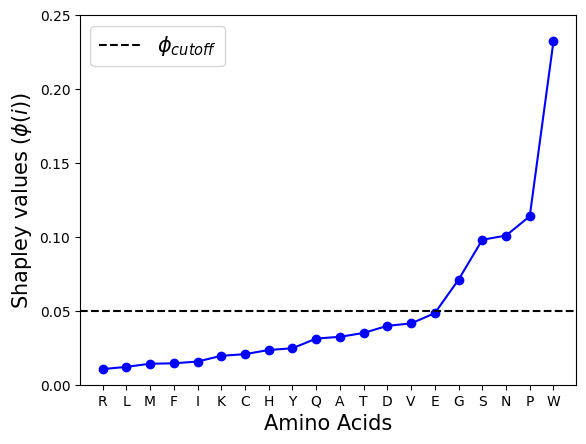

In [24]:
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [25]:
C1_suffix = 'Hba'
C2_suffix = 'Hbb'
 
p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)
p

Bokeh(GridPlot)

# trypsin / chymotrypsin

In [26]:
family_PATH = DATA_PATH + 'serine_proteases/'

In [27]:
C1_train_path = family_PATH+'trypsin_swissprot.csv'
C2_train_path = family_PATH+'chymotrypsin_swissprot.csv'
C1_test_path = family_PATH+'trypsin_trembl.csv'
C2_test_path = family_PATH+'chymotrypsin_trembl.csv'

-> Extracting features:


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████| 17/17 [00:00<00:00, 17454.88it/s]


C1 # 69 | C2 # 17
-> Filter identical sequences


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 310/310 [00:00<00:00, 18072.36it/s]


C1 # 3890 | C2 # 310
Filtered 4094 / 4200
Train | C1 # 66 | C2 # 17
Test  | C1 # 3813 | C2 # 281
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:14<00:00, 33.65it/s]


Full
{'train_mean_AM': 0.992, 'train_std_AM': 0.015, 'train_mean_acc': 0.988, 'train_std_acc': 0.024, 'test_AM': 0.873, 'test_acc': 0.844}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.977, 'train_std_AM': 0.031, 'train_mean_acc': 0.965, 'train_std_acc': 0.047, 'test_AM': 0.835, 'test_acc': 0.756}
AFS: ['Y', 'W', 'T', 'A', 'V', 'K', 'P']
AFS(C1): ['Y', 'A']
AFS(C2): ['W', 'T', 'V', 'K', 'P']


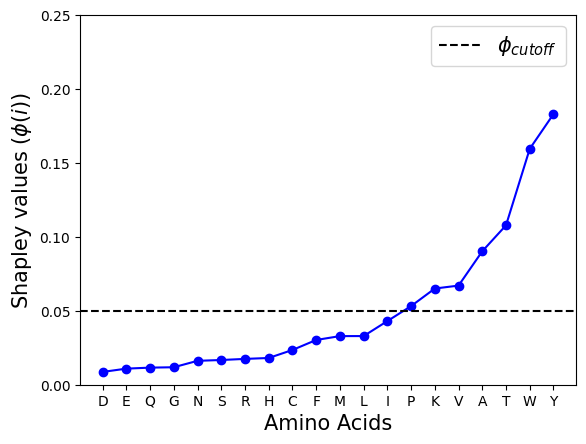

In [28]:
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [29]:
C1_suffix = 'Tryp'
C2_suffix = 'Chym'
 
p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)
p

Bokeh(GridPlot)

# Tubulin $\alpha$ vs $\beta$

In [30]:
family_PATH = DATA_PATH + 'tubulin/'

In [31]:
C1_train_path = family_PATH+'alpha_swissprot.csv'
C2_train_path = family_PATH+'beta_swissprot.csv'
C1_test_path = family_PATH+'alpha_trembl.csv'
C2_test_path = family_PATH+'beta_trembl.csv'

-> Extracting features:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 218/218 [00:00<00:00, 11004.03it/s]


C1 # 139 | C2 # 218
-> Filter identical sequences


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 558/558 [00:00<00:00, 11557.64it/s]


C1 # 239 | C2 # 558
Filtered 537 / 797
Train | C1 # 117 | C2 # 191
Test  | C1 # 190 | C2 # 347
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:29<00:00, 16.96it/s]


Full
{'train_mean_AM': 0.996, 'train_std_AM': 0.009, 'train_mean_acc': 0.997, 'train_std_acc': 0.006, 'test_AM': 0.992, 'test_acc': 0.991}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.995, 'train_std_AM': 0.006, 'train_mean_acc': 0.994, 'train_std_acc': 0.008, 'test_AM': 0.992, 'test_acc': 0.994}
AFS: ['M', 'Q', 'K', 'N', 'F', 'I', 'H', 'A', 'C', 'Y']
AFS(C1): ['K', 'I', 'H', 'C', 'Y']
AFS(C2): ['M', 'Q', 'N', 'F', 'A']


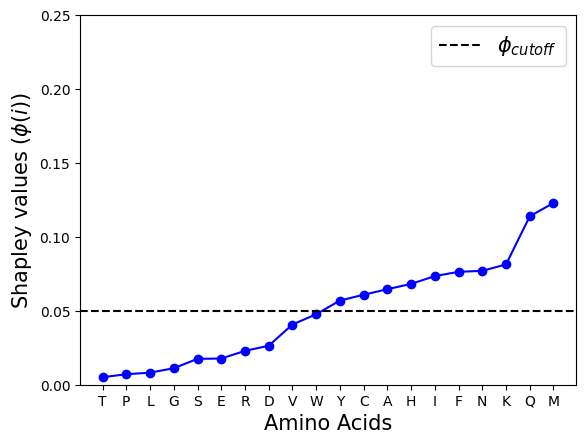

In [32]:
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [33]:
C1_suffix = 'alpha'
C2_suffix = 'beta'
 
p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)
p

Bokeh(GridPlot)

# GPCRs

In [34]:
family_PATH = DATA_PATH + 'GPCR/'

## Rhodopsin / Glutamate

-> Extracting features:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 112/112 [00:00<00:00, 5675.24it/s]


C1 # 226 | C2 # 112
-> Filter identical sequences
Train | C1 # 181 C2 # 89
Test  | C1 # 45 C2 # 23
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:36<00:00, 13.60it/s]


Full
{'train_mean_AM': 0.884, 'train_std_AM': 0.042, 'train_mean_acc': 0.867, 'train_std_acc': 0.038, 'test_AM': 0.967, 'test_acc': 0.956}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.85, 'train_std_AM': 0.045, 'train_mean_acc': 0.837, 'train_std_acc': 0.032, 'test_AM': 0.934, 'test_acc': 0.926}
AFS: ['D', 'Q', 'E', 'G', 'M', 'L']
AFS(C1): ['M', 'L']
AFS(C2): ['D', 'Q', 'E', 'G']


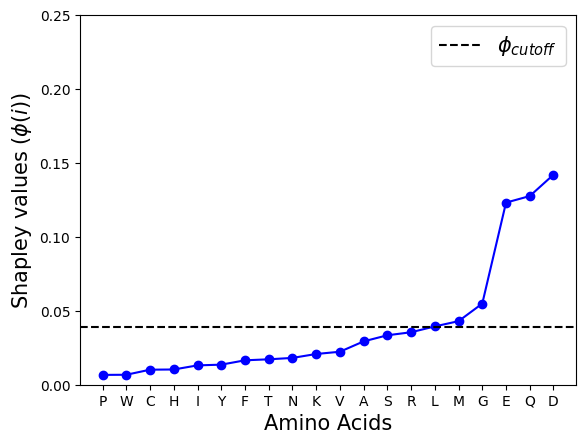

In [35]:
C1_train_path = family_PATH+'Rhodopsin-like.csv'
C2_train_path = family_PATH+'Glutamate-like.csv'
C1_test_path = None
C2_test_path = None
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

In [36]:
C1_suffix = 'Rho'
C2_suffix = 'Glu'
 

## Glutamate / Secretin

-> Extracting features:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 7847.48it/s]


C1 # 112 | C2 # 113
-> Filter identical sequences
Train | C1 # 90 C2 # 90
Test  | C1 # 22 C2 # 23
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:25<00:00, 19.86it/s]


Full
{'train_mean_AM': 0.933, 'train_std_AM': 0.042, 'train_mean_acc': 0.933, 'train_std_acc': 0.042, 'test_AM': 0.888, 'test_acc': 0.889}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.95, 'train_std_AM': 0.032, 'train_mean_acc': 0.95, 'train_std_acc': 0.032, 'test_AM': 0.845, 'test_acc': 0.844}
AFS: ['W', 'H', 'Y', 'V', 'D']
AFS(C1): ['V', 'D']
AFS(C2): ['W', 'H', 'Y']


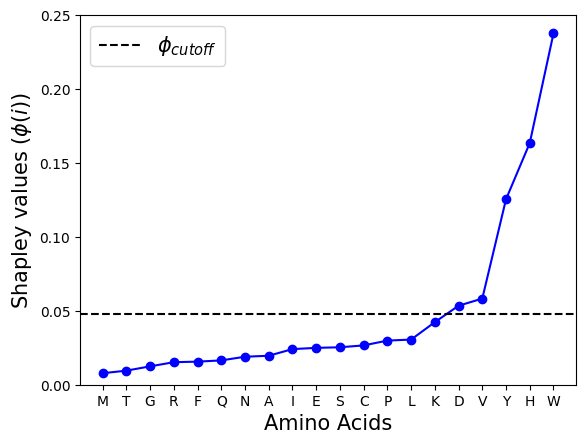

In [37]:
C1_train_path = family_PATH+'Glutamate-like.csv'
C2_train_path = family_PATH+'Secretin-like.csv'
C1_test_path = None
C2_test_path = None
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

In [38]:
C1_suffix = 'Glu'
C2_suffix = 'Sec'
 

## Rhodopsin / Secretin

-> Extracting features:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████| 113/113 [00:00<00:00, 7997.37it/s]


C1 # 226 | C2 # 113
-> Filter identical sequences
Train | C1 # 181 C2 # 90
Test  | C1 # 45 C2 # 23
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:35<00:00, 13.97it/s]


Full
{'train_mean_AM': 0.917, 'train_std_AM': 0.051, 'train_mean_acc': 0.908, 'train_std_acc': 0.06, 'test_AM': 0.934, 'test_acc': 0.941}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.878, 'train_std_AM': 0.065, 'train_mean_acc': 0.863, 'train_std_acc': 0.073, 'test_AM': 0.846, 'test_acc': 0.853}
AFS: ['W', 'E', 'M', 'S', 'V', 'H', 'Q', 'A']
AFS(C1): ['M', 'S', 'V', 'A']
AFS(C2): ['W', 'E', 'H', 'Q']


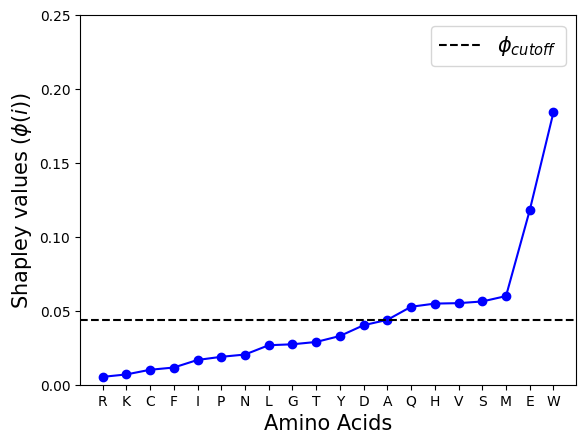

In [39]:
C1_train_path = family_PATH+'Rhodopsin-like.csv'
C2_train_path = family_PATH+'Secretin-like.csv'
C1_test_path = None
C2_test_path = None
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

In [40]:
C1_suffix = 'Rho'
C2_suffix = 'Sec'
 

## Rhodopsin-like sub families

### Aminergic / Lipid

-> Extracting features:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 144/144 [00:00<00:00, 13120.01it/s]


C1 # 239 | C2 # 144
-> Filter identical sequences
Train | C1 # 186 C2 # 113
Test  | C1 # 47 C2 # 28
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:37<00:00, 13.48it/s]


Full
{'train_mean_AM': 0.949, 'train_std_AM': 0.014, 'train_mean_acc': 0.943, 'train_std_acc': 0.017, 'test_AM': 0.922, 'test_acc': 0.92}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.943, 'train_std_AM': 0.005, 'train_mean_acc': 0.94, 'train_std_acc': 0.008, 'test_AM': 0.843, 'test_acc': 0.84}
AFS: ['L', 'P', 'E', 'W', 'F', 'M', 'D']
AFS(C1): ['P', 'E', 'W', 'D']
AFS(C2): ['L', 'F', 'M']


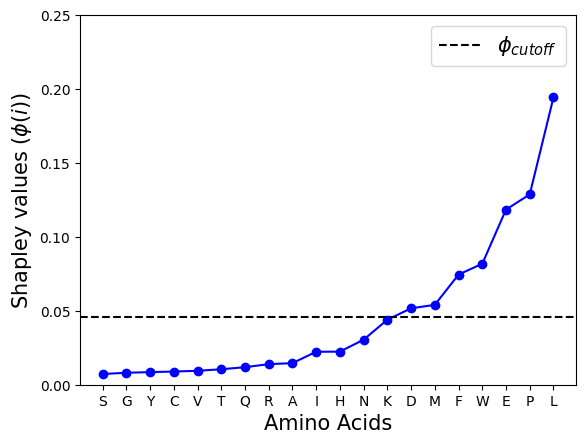

In [41]:
C1_train_path = family_PATH+'Aminergic receptors.csv'
C2_train_path = family_PATH+'Lipid receptors.csv'
C1_test_path = None
C2_test_path = None
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

In [42]:
C1_suffix = 'Ami'
C2_suffix = 'Lip'
 

### Aminergic / Peptide

-> Extracting features:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 12910.51it/s]


C1 # 239 | C2 # 465
-> Filter identical sequences
Train | C1 # 186 C2 # 367
Test  | C1 # 47 C2 # 92
Computing Shapley values


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:27<00:00,  5.73it/s]


Full
{'train_mean_AM': 0.835, 'train_std_AM': 0.06, 'train_mean_acc': 0.83, 'train_std_acc': 0.06, 'test_AM': 0.844, 'test_acc': 0.827}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.818, 'train_std_AM': 0.053, 'train_mean_acc': 0.819, 'train_std_acc': 0.051, 'test_AM': 0.79, 'test_acc': 0.784}
AFS: ['L', 'F', 'E', 'M', 'K', 'D', 'V', 'R']
AFS(C1): ['E', 'K', 'D', 'R']
AFS(C2): ['L', 'F', 'M', 'V']


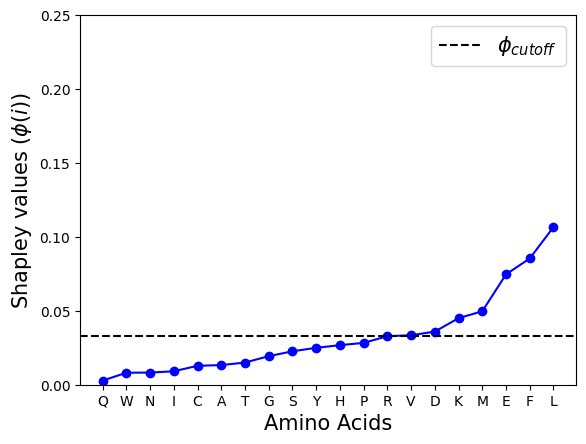

In [43]:
C1_train_path = family_PATH+'Aminergic receptors.csv'
C2_train_path = family_PATH+'Peptide receptors.csv'
C1_test_path = None
C2_test_path = None
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

In [44]:
C1_suffix = 'Ami'
C2_suffix = 'Pep'
 

### Lipid / Peptide

-> Extracting features:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 465/465 [00:00<00:00, 12801.78it/s]


C1 # 144 | C2 # 465
-> Filter identical sequences
Train | C1 # 113 C2 # 367
Test  | C1 # 28 C2 # 92
Computing Shapley values


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [01:18<00:00,  6.38it/s]


Full
{'train_mean_AM': 0.829, 'train_std_AM': 0.022, 'train_mean_acc': 0.838, 'train_std_acc': 0.018, 'test_AM': 0.845, 'test_acc': 0.858}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.76, 'train_std_AM': 0.035, 'train_mean_acc': 0.75, 'train_std_acc': 0.032, 'test_AM': 0.709, 'test_acc': 0.725}
AFS: ['P', 'R', 'G', 'I', 'W', 'S', 'V']
AFS(C1): ['R', 'G', 'S']
AFS(C2): ['P', 'I', 'W', 'V']


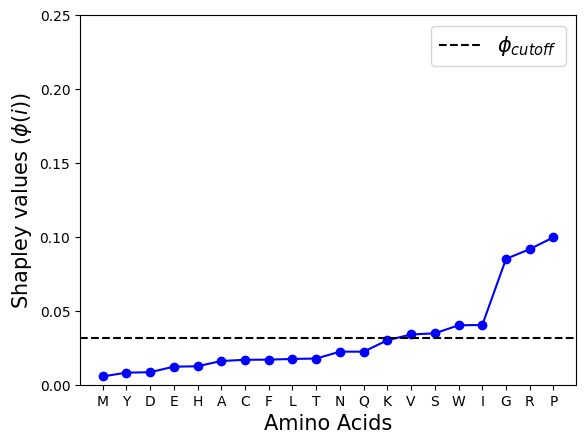

In [45]:
C1_train_path = family_PATH+'Lipid receptors.csv'
C2_train_path = family_PATH+'Peptide receptors.csv'
C1_test_path = None
C2_test_path = None
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

In [46]:
C1_suffix = 'Lip'
C2_suffix = 'Pep'
 

# Interleukin $\alpha$ vs $\beta$

In [47]:
family_PATH = DATA_PATH + 'interleukin/'

-> Extracting features:


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████| 26/26 [00:00<00:00, 17378.79it/s]


C1 # 16 | C2 # 26
-> Filter identical sequences


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 216/216 [00:00<00:00, 17732.12it/s]


C1 # 12 | C2 # 216
Filtered 206 / 228
Train | C1 # 16 | C2 # 25
Test  | C1 # 12 | C2 # 194
Computing Shapley values


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:11<00:00, 41.97it/s]


Full
{'train_mean_AM': 0.98, 'train_std_AM': 0.04, 'train_mean_acc': 0.975, 'train_std_acc': 0.05, 'test_AM': 0.979, 'test_acc': 0.961}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.98, 'train_std_AM': 0.04, 'train_mean_acc': 0.975, 'train_std_acc': 0.05, 'test_AM': 0.985, 'test_acc': 0.971}
AFS: ['C', 'G', 'T', 'S', 'V', 'Q', 'A', 'N', 'P']
AFS(C1): ['T', 'S', 'A', 'N']
AFS(C2): ['C', 'G', 'V', 'Q', 'P']


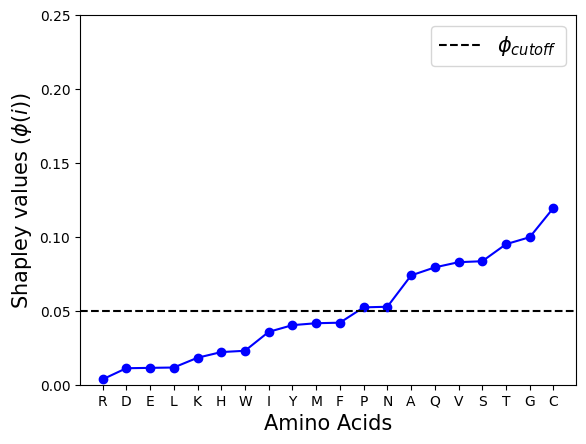

In [48]:
C1_train_path = family_PATH+'il1_alpha_swissprot.csv'
C2_train_path = family_PATH+'il1_beta_swissprot.csv'
C1_test_path = family_PATH+'il1_alpha_trembl.csv'
C2_test_path = family_PATH+'il1_beta_trembl.csv'
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [49]:
C1_suffix = 'il1a'
C2_suffix = 'il1b'
 
get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)

Bokeh(GridPlot)

# Histone H2A vs Histone H2B

In [50]:
family_PATH = DATA_PATH + 'histone/'

-> Extracting features:


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 201/201 [00:00<00:00, 28772.23it/s]


C1 # 239 | C2 # 201
-> Filter identical sequences


100%|████████████████████████████████████████████████████████████████████████████████████████████████████| 10965/10965 [00:00<00:00, 35425.08it/s]


C1 # 22311 | C2 # 10965
Filtered 24198 / 33276
Train | C1 # 180 | C2 # 177
Test  | C1 # 16599 | C2 # 7599
Computing Shapley values


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:34<00:00, 14.46it/s]


Full
{'train_mean_AM': 0.983, 'train_std_AM': 0.016, 'train_mean_acc': 0.983, 'train_std_acc': 0.016, 'test_AM': 0.91, 'test_acc': 0.889}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.983, 'train_std_AM': 0.01, 'train_mean_acc': 0.983, 'train_std_acc': 0.01, 'test_AM': 0.934, 'test_acc': 0.922}
AFS: ['L', 'G', 'S', 'M', 'K', 'N', 'T', 'Y', 'F']
AFS(C1): ['L', 'G', 'N']
AFS(C2): ['S', 'M', 'K', 'T', 'Y', 'F']


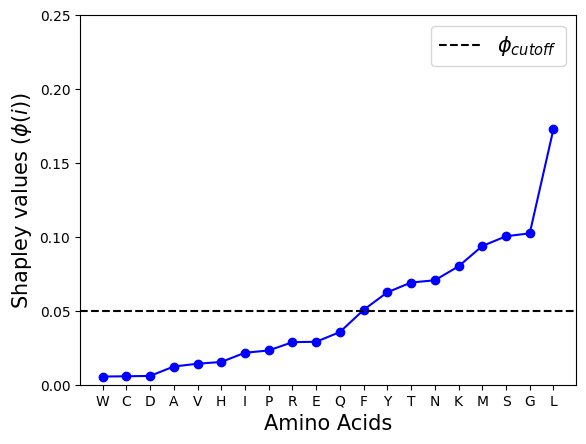

In [51]:
C1_train_path = family_PATH+'h2a_swissprot.csv'
C2_train_path = family_PATH+'h2b_swissprot.csv'
C1_test_path = family_PATH+'h2a_trembl.csv'
C2_test_path = family_PATH+'h2b_trembl.csv'
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [52]:
C1_suffix = 'h2a'
C2_suffix = 'h2b'
 
p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=False)
p

Bokeh(GridPlot)

# Cytochrome P450 CYP3 vs CYP5

In [53]:
family_PATH = DATA_PATH + 'cytochromep450/'

-> Extracting features:


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 34/34 [00:00<00:00, 9320.68it/s]


C1 # 32 | C2 # 34
-> Filter identical sequences


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 643/643 [00:00<00:00, 10055.06it/s]


C1 # 834 | C2 # 643
Filtered 1419 / 1477
Train | C1 # 32 | C2 # 32
Test  | C1 # 818 | C2 # 601
Computing Shapley values


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████| 500/500 [00:13<00:00, 36.87it/s]


Full
{'train_mean_AM': 0.967, 'train_std_AM': 0.041, 'train_mean_acc': 0.969, 'train_std_acc': 0.038, 'test_AM': 0.902, 'test_acc': 0.894}
AFS
_________________________**SVEA**_________________________
{'train_mean_AM': 0.933, 'train_std_AM': 0.062, 'train_mean_acc': 0.936, 'train_std_acc': 0.062, 'test_AM': 0.92, 'test_acc': 0.908}
AFS: ['H', 'F', 'G', 'K', 'A', 'P', 'N']
AFS(C1): ['F', 'K', 'P', 'N']
AFS(C2): ['H', 'G', 'A']


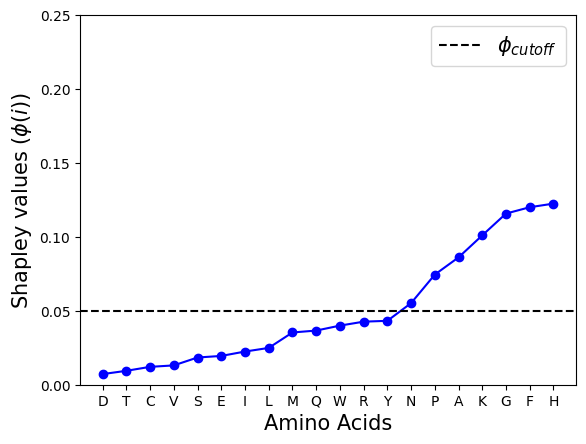

In [54]:
C1_train_path = family_PATH+'cyp3_swissprot.csv'
C2_train_path = family_PATH+'cyp51_swissprot.csv'
C1_test_path = family_PATH+'cyp3_trembl.csv'
C2_test_path = family_PATH+'cyp51_trembl.csv'
C1_afs, C2_afs, SV_vals, plt = get_results(C1_train_path, C2_train_path, C1_test_path, C2_test_path, feature_extractor)

## MSA with SV color code

In [55]:
C1_suffix = 'cyp3'
C2_suffix = 'cyp5'
 
p = get_MSA(C1_train_path, C2_train_path, C1_afs, C2_afs, SV_vals, C1_suffix, C2_suffix, aln_saved=True)
p

FileNotFoundError: [Errno 2] No such file or directory: './datasets/cytochromep450/cyp3_swissprot15cyp51_swissprot15.aln'